In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image  # Import Image from PIL
import requests
import json
import open_clip
import torch
import os

# Define the path where the fashion dataset is stored
FASHION_DATASET_HOME = '/home/jcaldeira/dressing_virtuel_data_collector/media/images/'
#image = '0c0bfbde088d5b2f94f10b47f5b6352c28cbc148.jpg'
image = '100_0144.JPG'
image = '20150501_161427.jpg'
#image = '100_0532.JPG'

# API endpoint to send requests
ENDPOINT = 'http://127.0.0.1:5000/dressing_virtuel'
ENDPOINT_CAT = 'http://127.0.0.1:5001/categorization_model'
ENDPOINT_SEG = 'http://127.0.0.1:5002/segmentation_model'

def get_categories(method, key):
    """
    Fetches categories (like gender, color, season, etc.) from the API.

    Args:
        method (str): API method to fetch (e.g., 'genders', 'colors').
        key (str): The key to extract from the API response (e.g., 'name', 'id').

    Returns:
        dict: A dictionary with category names as keys and their 
        corresponding IDs as values.
    """
    response = requests.get(f"{ENDPOINT}/{method}")
    dict = {x[key]: x['id'] for x in response.json()}

    return dict

def clip_evaluation(subcategories, image_path):
    json_post_image = {"path": image_path, "list_of_categories": subcategories}
    response = requests.get(f"{ENDPOINT_CAT}/fit_category", 
                            data = json.dumps(json_post_image))
    return response.json()

def clip_evaluation_dict(subcategories, image_path):
    json_post_image = {"path": image_path, "dict_of_categories": subcategories}
    response = requests.get(f"{ENDPOINT_CAT}/fit_categories", 
                            data = json.dumps(json_post_image))
    return response.json()

def seg_evaluation(image_path):
    json_post_image = {"path": image_path}
    response = requests.get(f"{ENDPOINT_SEG}/crop_single_clothes",
                            data = json.dumps(json_post_image))
    return response.json()

def seg_fullbody_evaluation(image_path):
    json_post_image = {"path": image_path}
    response = requests.get(f"{ENDPOINT_SEG}/crop_fullbody_clothes",
                            data = json.dumps(json_post_image))
    return response.json()


In [4]:
# Fetch categories from the API and store them in dictionaries
print('Getting Categories from Database ...')
dict_genders = get_categories('genders','gender')
dict_seasons = get_categories('seasons','name')
dict_colors = get_categories('colors','name')
dict_usage = get_categories('usage_types','name')
dict_article = get_categories('article_types','name')



Getting Categories from Database ...


In [5]:
# Loop through all images in the dataset
image_path = FASHION_DATASET_HOME + '/' + image

print('Executing the segmentation over the image...')
#new_image = seg_evaluation(image_path)
new_image = seg_fullbody_evaluation(image_path)
print(new_image)



Executing the segmentation over the image...
['/home/jcaldeira/dressing_virtuel_data_collector/media/tmp/image_1727940949_vxl2ga.png']


Extracting the categories from the cropped image ...


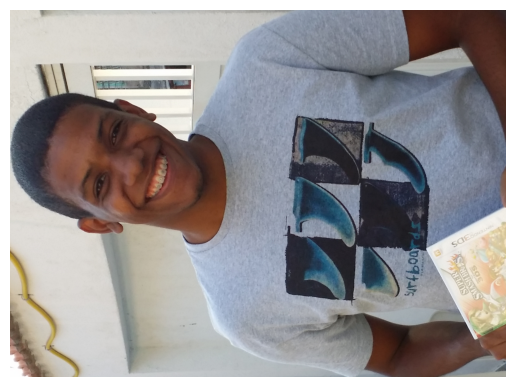

path: /home/jcaldeira/dressing_virtuel_data_collector/media/tmp/image_1727940949_vxl2ga.png
{'gender': 'Men', 'season': 'Summer', 'color': 'Grey', 'usage': 'Casual', 'article': 'Lounge Tshirts'}


In [6]:
for image_path in new_image:
    print('Extracting the categories from the cropped image ...')
    dict_of_categories = {
        'gender': list(dict_genders.keys()),
        'season': list(dict_seasons.keys()),
        'color': list(dict_colors.keys()),
        'usage': list(dict_usage.keys()),
        'article': list(dict_article.keys())
    }
    # Perform CLIP evaluation to get the best matching category for each attribute
    selected_categories = clip_evaluation_dict(dict_of_categories,image_path)

    with open(image_path, 'rb') as path:
        image = Image.open(image_path)
        plt.imshow(image)
        plt.axis('off')  # Turn off the axis
        plt.show()

    print(f"path: {image_path}")
    print(selected_categories)

Extracting the categories from the cropped image ...


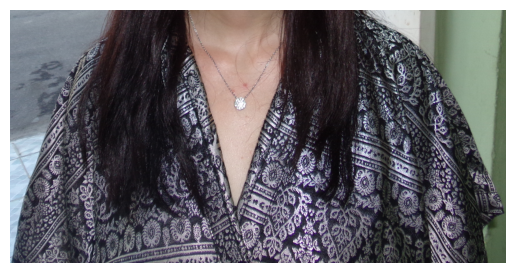

{'id': 0, 'path': '/home/jcaldeira/dressing_virtuel_data_collector/media/tmp/image_1727862019_qu73cq.png', 'id_usagetype': 'Ethnic', 'id_gender': 'Unisex', 'id_color': 'Silver', 'id_season': 'Winter', 'id_articletype': 'Robe'}


In [14]:
for image_path in new_image:
    print('Extracting the categories from the cropped image ...')
    # Perform CLIP evaluation to get the best matching category for each attribute
    gender = clip_evaluation(list(dict_genders.keys()),image_path)
    season = clip_evaluation(list(dict_seasons.keys()),image_path)
    color = clip_evaluation(list(dict_colors.keys()),image_path)
    usage = clip_evaluation(list(dict_usage.keys()),image_path)
    article = clip_evaluation(list(dict_article.keys()),image_path)

    with open(image_path, 'rb') as path:
        image = Image.open(image_path)
        plt.imshow(image)
        plt.axis('off')  # Turn off the axis
        plt.show()

    # Create a JSON object to send to the API
    json_post_image = {"id":0,
                        "path":image_path, 
                        "id_usagetype":usage,
                        "id_gender":gender,
                        "id_color":color,
                        "id_season":season,
                        "id_articletype":article}

    print(json_post_image)

In [25]:

from transformers import AutoModel, AutoProcessor

model = AutoModel.from_pretrained('Marqo/marqo-fashionSigLIP', trust_remote_code=True)
processor = AutoProcessor.from_pretrained('Marqo/marqo-fashionSigLIP', trust_remote_code=True)

model.save('clip_model/offline_model/marqo-fashionSigLIP')


config.json:   0%|          | 0.00/302 [00:00<?, ?B/s]

marqo_fashionSigLIP.py:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/Marqo/marqo-fashionSigLIP:
- marqo_fashionSigLIP.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
You are using a model of type siglip to instantiate a model of type . This is not supported for all configurations of models and can yield errors.


model.safetensors:   0%|          | 0.00/813M [00:00<?, ?B/s]

/home/jcaldeira/dressing_virtuel_data_collector/.venv/lib/python3.10/site-packages/open_clip/factory.py:129: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch

preprocessor_config.json:   0%|          | 0.00/516 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/20.6k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.53k [00:00<?, ?B/s]

AttributeError: 'MarqoFashionSigLIP' object has no attribute 'save'